In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import pickle as pkl
import os
import time
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
class_mapping = {}
with open('../dbpedia_csv/classes.txt') as txt_file:
    line_num = 1
    for line in txt_file:
        class_mapping[line_num-1] = line.strip()
        line_num+=1
        
print(class_mapping)

{0: 'Company', 1: 'EducationalInstitution', 2: 'Artist', 3: 'Athlete', 4: 'OfficeHolder', 5: 'MeanOfTransportation', 6: 'Building', 7: 'NaturalPlace', 8: 'Village', 9: 'Animal', 10: 'Plant', 11: 'Album', 12: 'Film', 13: 'WrittenWork'}


### Define Data Generator

In [3]:
class WordSequenceDataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, batch_size=32,
                 n_classes=14, shuffle=True):
        'Initialization'
        self.dim = (300,)
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate index of the batch
        indexes = self.indexes[index:(index+1)]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype = int)
        for item in list_IDs_temp:
            Xarray = pkl.load(open('dbpedia/Training/'+item, 'rb'))
        for i, row in enumerate(Xarray[1]):
            X[i,] = Doc2Vec_model.infer_vector(row)
            y[i] = Xarray[0]-1
            
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

# Train Doc2Vec

In [ ]:
Doc2Vec_train_data = list(pd.read_csv('dbpedia/dbpedia_csv/train.csv', header = -1,
                                      names = ['ClassIndex', 'Title', 'Content'])['Content'])
tagged_Doc2Vec_train_data = [TaggedDocument(words = word_tokenize(_d.lower()),
                                            tags = [i]) for i, _d in enumerate(Doc2Vec_train_data)]
del Doc2Vec_train_data

start = time.time()
max_epochs = 10
vector_size = 300

model = Doc2Vec(vector_size = vector_size, min_count = 2, workers = 4, epochs = max_epochs)
model_build_time = time.time()
print("Built model in {}".format(model_build_time-start))

model.build_vocab(tagged_Doc2Vec_train_data)
build_vocab_time = time.time()
print("Built vocab in {}".format(build_vocab_time-model_build_time))

model.train(tagged_Doc2Vec_train_data, total_examples=model.corpus_count, epochs = model.epochs)
end = time.time()
print("Trained model in {}".format(end-build_vocab_time))
model.save("Doc2Vec.model")

## Load Trained Doc2Vec Model

In [ ]:
Doc2Vec_model = Doc2Vec.load("Doc2Vec.model")
Doc2Vec_model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
partition, labels = pkl.load(open('dbpedia/Training/Metadata', 'rb'))
for key in labels.keys():
    labels[key] -= 1

In [ ]:
params = {'batch_size':32, 'n_classes': 14, 'shuffle': True}
training_generator = WordSequenceDataGenerator(partition['train'], **params)
validation_generator = WordSequenceDataGenerator(partition['validation'], **params)

### Training

In [ ]:
model.name = 'Doc2VecNN'

if os.exists(model.name+'.hdf5'):
    model = keras.models.load_model('Sequential_3.hdf5')
else:
    model = Sequential()
    model.add(Dense(128, activation = 'relu', input_dim = 300))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(14, activation = 'softmax'))
    model.compile(optimizer = 'Nadam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

loss_acc_path = model.name+'loss_acc'
history = model.fit_generator(generator = training_generator, epochs = 5, validation_data = validation_generator, verbose = 1)
loss_acc = {}
if os.path.exists(loss_acc_path):
    loss_acc = pkl.load(open(loss_acc_path, 'rb'))
    loss_acc['acc'] = loss_acc['acc'] + history.history['acc']
    loss_acc['loss'] = loss_acc['loss'] + history.history['loss']
else:
    loss_acc['acc'] = history.history['acc']
    loss_acc['loss'] = history.history['loss']
pkl.dump(loss_acc,open(loss_acc_path, 'wb'))
model.save(model.name+'.hdf5')

### Testing

In [ ]:
model.name = Doc2VecNN
model = keras.models.load_model(model.name+'.hdf5')
Doc2Vec_model = Doc2Vec.load("Doc2Vec.model")
Doc2Vec_model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [ ]:
start = time.time()
accuracies = {}
for label in os.listdir('dbpedia/Testing'):
    accuracies[label] = {}
    for sent_len in os.listdir('dbpedia/Testing/{}/'.format(label)):
        Xtest = np.empty((0,300))
        labels = []
        for file in os.listdir('dbpedia/Testing/{}/{}/'.format(label,sent_len)):
            sample = pkl.load(open('dbpedia/Testing/{}/{}/{}'.format(label,sent_len,file), 'rb'))
            labels.append(sample[0])
            Xtest = np.vstack((Xtest, Doc2Vec_model.infer_vector(sample[1])))
        result = model.predict(Xtest)
        result = np.argmax(result,axis = 1)+1
        accuracy = np.sum(result == labels)/len(labels)
        print('{}, sentence length: {}, Accuracy: {}'.format(label,sent_len,np.sum(result == labels)/len(labels)))
        accuracies[label][sent_len] = accuracy
        print('elapsed time: {}'.format((time.time()-start)/60))
pkl.dump(accuracies, open(model.name+'Accuracy', 'wb'))

In [ ]:
accs = pkl.load(open(model.name+'Accuracy', 'rb'))

In [5]:
accuracies = pd.DataFrame([accs[key] for key in accs.keys()]).rename(index = class_mapping)
accuracies = accuracies.reindex(sorted(list(accuracies.columns), key = int), axis = 1).transpose()
accuracies['Total Accuracy'] = accuracies.sum(axis=1)/14
accuracies['Number of Words'] = accuracies.index.astype(int)

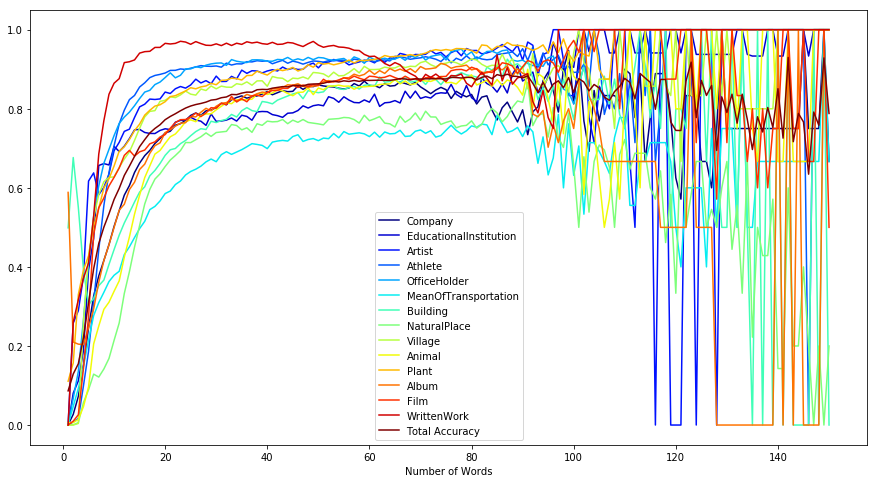

In [6]:
accuracies.plot(x ='Number of Words', figsize = (15,8), colormap = 'jet')
plt.show()

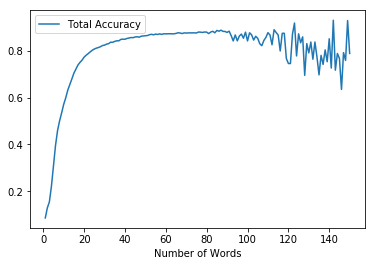

In [7]:
accuracies.plot(x = 'Number of Words', y = 'Total Accuracy')
plt.show()